In [12]:
%cd ..

/Users/treycole/Codes


In [13]:
from WanPy.pythtb_Wannier import *
import WanPy.models as models
import WanPy.plotting as plot

from pythtb import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sympy as sp 
import scipy

In [14]:
delta = 1
t0 = 0.1
tprime = 0.5

model = models.chessboard(t0, tprime, delta).make_supercell([[2,0], [0,2]])

orbs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)
lat_vecs = model.get_lat() # lattice vectors

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)

In [15]:
u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print(f"Chern number: {chern:.2f}")

Chern number: -1.00


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': '$C = -1.0$ | $\\Delta = 1,\\ t = -1,\\ t_2 = 0.2$'}, ylabel='Energy $E(\\mathbf{{k}})$ '>)

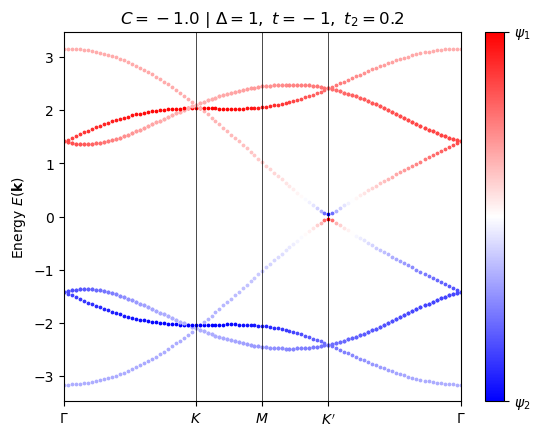

In [16]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $')
title = title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t = {t},\ t_2 = {t2}$")

plot.plot_bands(
    model, k_path=k_path, k_label=k_label, sub_lat=True, red_lat_idx=high_E_sites, title=title)

In [17]:
# 2D k-mesh
nkx = 20
nky = 20
Nk = nkx*nky

k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)
k_mesh_flat = gen_k_mesh(nkx, nky, flat=True, endpoint=False)

u_wfs_Wan = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs_Wan.solve_on_one_point(k_mesh[i,j], [i,j])

In [18]:
omit_sites = 4
tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site

In [19]:
w0, psi_til_wan = Wannierize(orbs, u_wfs_Wan, tf_list, ret_psi_til=True)
u_tilde_wan = get_bloch_wfs(orbs, psi_til_wan, k_mesh, inverse=True)

In [20]:
M = k_overlap_mat(lat_vecs, orbs, u_tilde_wan) # [kx, ky, b, m, n]
spread, expc_rsq, expc_r_sq = spread_recip(lat_vecs, M, decomp=True)

print(rf"Spread from M_kb of \tilde{{u_nk}} = {spread[0]}")
print(rf"Omega_I from M_kb of \tilde{{u_nk}} = {spread[1]}")
print(rf"Omega_til from M_kb \tilde{{u_nk}} = {spread[2]}")

Spread from M_kb of \tilde{u_nk} = (0.8395353683809148+0j)
Omega_I from M_kb of \tilde{u_nk} = 0.628269109354029
Omega_til from M_kb \tilde{u_nk} = (0.21126625902692164+0j)


In [21]:
# spread, expc_rsq, expc_r_sq = spread_real(model, w0, decomp=True)

# print(rf"Spread from w0 = {spread[0]}")
# print(rf"Omega_I from w0 = {spread[1]}")
# print(rf"Omega_til from w0 = {spread[2]}")

([<Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 1 Axes>],
 [<Axes: title={'center': '$C = -1.0$ | $\\Delta = 1,\\ t = -1,\\ t_2 = 0.2$\nTrial fxns on sites [0, 2, 6]'}>,
  <Axes: title={'center': '$C = -1.0$ | $\\Delta = 1,\\ t = -1,\\ t_2 = 0.2$\nTrial fxns on sites [0, 2, 6]'}>,
  <Axes: title={'center': '$C = -1.0$ | $\\Delta = 1,\\ t = -1,\\ t_2 = 0.2$\nTrial fxns on sites [0, 2, 6]'}, xlabel='$|\\mathbf{r}|$', ylabel='$|w_0(\\mathbf{r})|^2$'>])

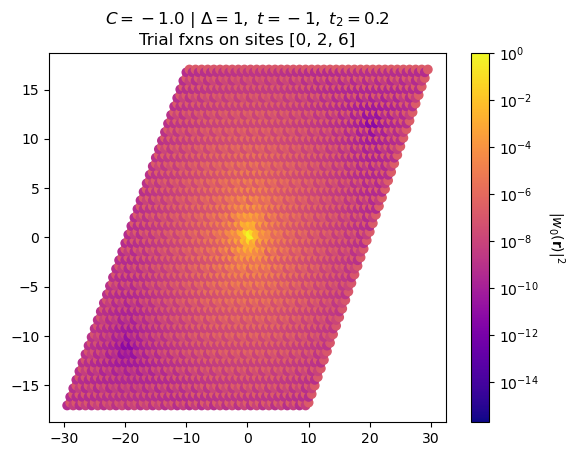

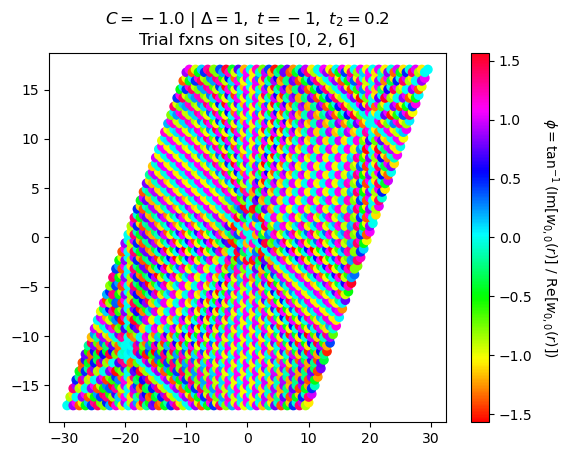

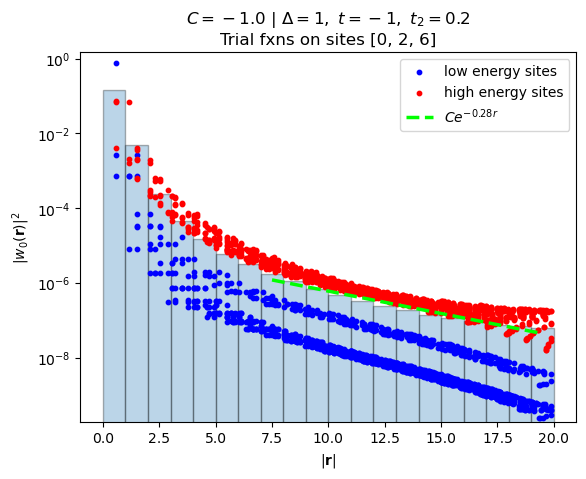

In [22]:
idx = 0
title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t = {t},\ t_2 = {t2}$"
        "\n" 
        rf"Trial fxns on sites {tf_list}"
         )
save_name = f'w_{idx}_scatter_C={chern:.1f}_Delta={delta}_t={t}_t2={t2}_tfxs={tf_list}.png'

plot.plot_Wan(w0, idx, orbs, lat_vecs, title=title, plot_phase=True, plot_decay=True, fit_rng=[7, 20])

0 Omega_I: 91.50150527538
1 Omega_I: 0.9434791603846118
2 Omega_I: 0.6158382423563012
3 Omega_I: 0.6356170901550295
4 Omega_I: 0.6207852669029924
5 Omega_I: 0.6107290751399657
6 Omega_I: 0.6100157981083766
7 Omega_I: 0.6073872442794134
8 Omega_I: 0.6008502223939306
9 Omega_I: 0.5993389766279811
10 Omega_I: 0.5962858006031443
11 Omega_I: 0.5916484997070143
12 Omega_I: 0.5893079257012646
13 Omega_I: 0.5862492264102711
14 Omega_I: 0.5825562001535722
15 Omega_I: 0.5799834786494691
16 Omega_I: 0.5770961452154381
17 Omega_I: 0.5740181007554418
18 Omega_I: 0.5714919547988588
19 Omega_I: 0.568861307797633
20 Omega_I: 0.5662130694104669
21 Omega_I: 0.5638524036002858
22 Omega_I: 0.5614841051175817
23 Omega_I: 0.5591564496729011
24 Omega_I: 0.5569939467044333
25 Omega_I: 0.554862806735993
26 Omega_I: 0.5527871505462464
27 Omega_I: 0.5508176063137011
28 Omega_I: 0.5488920543388792
29 Omega_I: 0.5470217026522922
30 Omega_I: 0.545226789778193
31 Omega_I: 0.5434774280543752
32 Omega_I: 0.54177835901

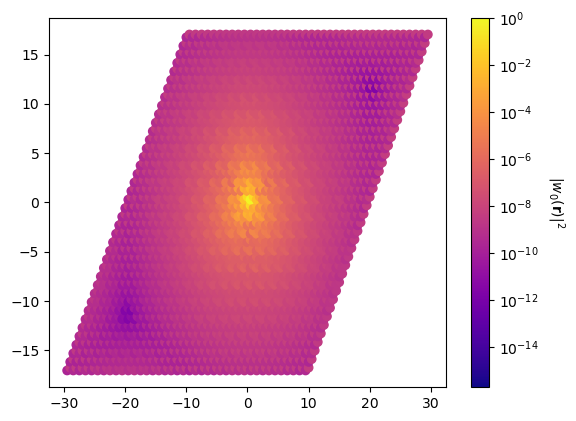

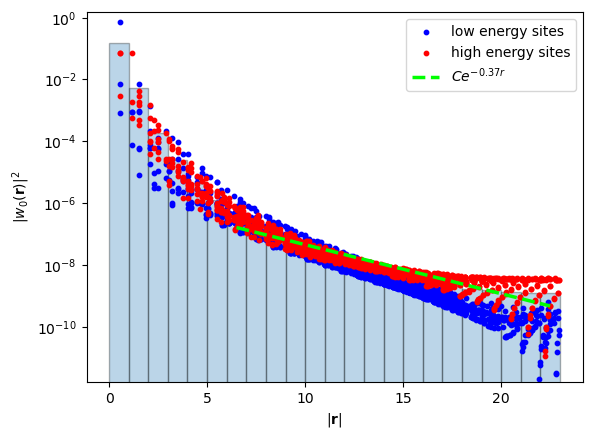

([<Figure size 640x480 with 2 Axes>, <Figure size 640x480 with 1 Axes>],
 [<Axes: >, <Axes: xlabel='$|\\mathbf{r}|$', ylabel='$|w_0(\\mathbf{r})|^2$'>])

In [23]:
# outer window of entangled bands is full occupied manifold
outer_states = u_wfs_Wan._wfs[..., :n_occ, :]
W0_max_loc, Wf_cntrs = max_loc_Wan(lat_vecs, orbs, u_wfs_Wan, tf_list, outer_states, 
        iter_num_omega_i=100, iter_num_omega_til=100,
        state_idx=None, verbose=True, return_uwfs=False, return_wf_centers=True, eps=2e-3
        )

Wan_idx = 0
plot.plot_Wan(W0_max_loc, Wan_idx, orbs, lat_vecs, plot_decay=True, show=True)